### Imports

In [1]:
%matplotlib widget
%cd ../../..
import logging
# logging.basicConfig(level=logging.INFO)
import os
import re

from linetimer import CodeTimer
import matplotlib.pyplot as plt
import nibabel
from nibabel import processing, nifti1, affines
import numpy as np
from scipy.ndimage import median_filter
from skimage.metrics import mean_squared_error, normalized_root_mse

from BabelBrain.GPUFunctions.GPUMedianFilter import MedianFilter

c:\Users\alanc\miniconda3\envs\bbl_dev\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\alanc\OneDrive\Documents\GitHub\BabelBrain


### GPU Initialization

In [2]:
# GPUBackend='CUDA'
GPUBackend='OpenCL'
# GPUBackend='Metal'
gpu_name = '3060'

MedianFilter.InitMedianFilter(gpu_name,GPUBackend=GPUBackend)

NVIDIA GeForce RTX 3060
Selecting device:  NVIDIA GeForce RTX 3060


c:\Users\alanc\miniconda3\envs\bbl_dev\lib\site-packages\pyopencl\__init__.py:270: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


### Load Input Data

In [3]:
fname = 'C:/Users/alanc/Documents/NeuroFUS/BabelBrain_Test_Data/SDR_0p55/CT.nii.gz'
base_name,_ = os.path.splitext(os.path.splitext(fname)[0])
nifti=nibabel.load(fname)
data=np.ascontiguousarray(nifti.get_fdata().astype(np.uint8))

### Determine Output Data Resolution

In [4]:
# Set desired spatial step
resolutions = {
    'low_freq_low_ppw': 0.919,    # 200 kHz,   6 PPW
    'low_freq_med_ppw': 0.613,    # 200 kHz,   9 PPW
    'low_freq_high_ppw': 0.459,   # 200 kHz,  12 PPW
    'med_freq_low_ppw': 0.306,    # 600 kHz,   6 PPW
    'med_freq_med_ppw': 0.204,    # 600 kHz,   9 PPW
    'med_freq_high_ppw': 0.153,   # 600 kHz,  12 PPW
    'high_freq_low_ppw': 0.184,   # 1000 kHz,  6 PPW
    'high_freq_med_ppw': 0.123,   # 1000 kHz,  9 PPW
    'high_freq_high_ppw': 0.092,  # 1000 kHz, 12 PPW
}
spatial_step = np.full(3,resolutions['low_freq_low_ppw'])
# spatial_step = np.asarray(nifti.header.get_zooms())/2
spatial_step_text = re.sub("\.","_",str(spatial_step[0]))

# Calculate new affine
zooms = np.asarray(nifti.header.get_zooms())
print(f"Original zooms: {zooms}")
print(f"New zooms: {spatial_step}")
new_x = int(nifti.shape[0]/(spatial_step[0]/zooms[0]))
new_y = int(nifti.shape[1]/(spatial_step[1]/zooms[1]))
new_z = int(nifti.shape[2]/(spatial_step[2]/zooms[2]))
affine_upscaled = affines.rescale_affine(nifti.affine.copy(),
                                         nifti.shape,
                                         spatial_step,
                                         (new_x,new_y,new_z))

# Output dimensions
output_data = np.zeros((new_x,new_y,new_z),dtype=np.uint8)
output_nifti = nifti1.Nifti1Image(output_data,affine_upscaled)
print(f"Output Dimensions: {output_data.shape}")
print(f"Output Size: {output_data.size}")

Original zooms: [0.44921893 0.449219   0.6255521 ]
New zooms: [0.919 0.919 0.919]
Output Dimensions: (250, 269, 179)
Output Size: 12037750


### Run Resample Step

In [5]:
# Set resample order and mode (default is 3 and 'constant')
order = 0
mode = 'constant' #'nearest'

resampled_fname = base_name + f"_resampled_CPU_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
if os.path.exists(resampled_fname):
    print('Reloading file')
    resampled_data = np.ascontiguousarray(nibabel.load(resampled_fname).get_fdata().astype(np.uint8))
else:
    print('Generating file')
    resampled_nifti = processing.resample_from_to(nifti,output_nifti,mode=mode,order=order,cval=data.min()) # Truth method
    print('Saving file')
    nibabel.save(resampled_nifti,resampled_fname)
    print('Reloading file')
    resampled_data=np.ascontiguousarray(resampled_nifti.get_fdata().astype(np.uint8))

Reloading file


### Run Median Filter Step

In [6]:
# Set median filter size
sf=7

with CodeTimer("GPU Median Filter", unit="s"):
    data_median_filter_gpu=MedianFilter.MedianFilter(resampled_data,sf,GPUBackend=GPUBackend)

with CodeTimer("CPU Median Filter", unit="s"):
    mf_truth_fname = base_name + f"_median_filter_CPU_mode_{mode}_order_{order}_size_{sf}_spatial_step_{spatial_step_text}.nii.gz"
    if os.path.exists(mf_truth_fname):
        print("Reloading CPU file")
        data_median_filter_cpu = nibabel.load(mf_truth_fname).get_fdata()
    else:
        print('Generating CPU file')
        data_median_filter_cpu=median_filter(resampled_data,sf)
        nifti_mf_cpu = nibabel.Nifti1Image(data_median_filter_cpu,affine_upscaled)
        print('Saving CPU file')
        nibabel.save(nifti_mf_cpu,mf_truth_fname)

if data_median_filter_gpu.size != data_median_filter_cpu.size:
    print(f"Array sizes don't match: {data_median_filter_gpu.size} vs {data_median_filter_cpu.size}")
if data_median_filter_gpu.size == 0:
    print("Arrays are empty")
if data_median_filter_gpu.size == data_median_filter_cpu.dtype:
    print("Arrays have different dtypes, changing them to match")
    data_median_filter_gpu.astype(data_median_filter_cpu.dtype)

Code block 'GPU Median Filter' took: 0.75496 s
Reloading CPU file
Code block 'CPU Median Filter' took: 0.05452 s


### Plot Data

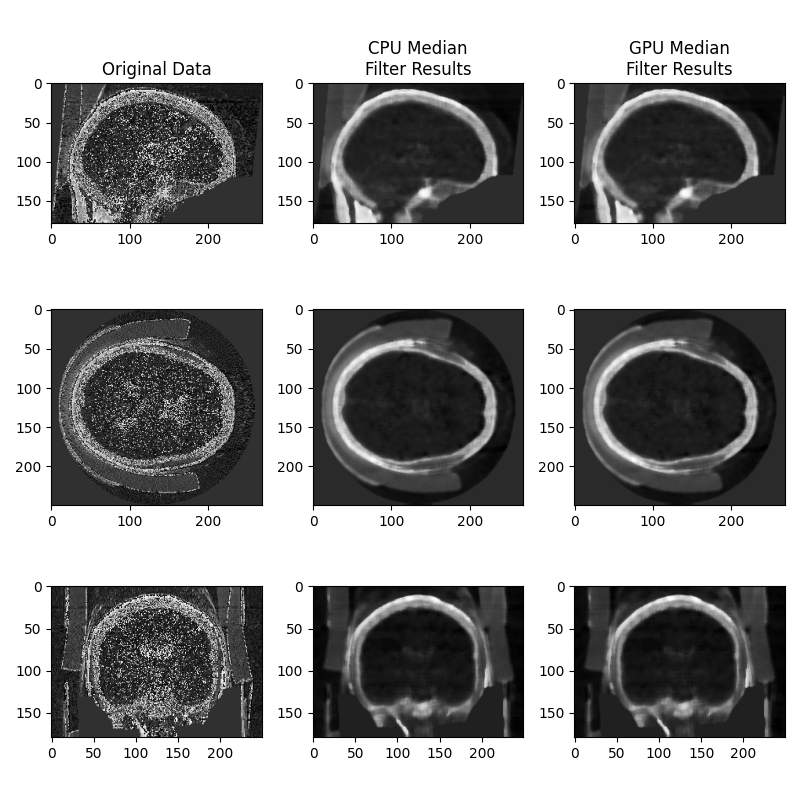

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

slice_num = resampled_data.shape[0]//2
axs[0,0].set_title("Original Data")
axs[0,0].imshow(np.rot90(resampled_data[slice_num,:,:]), cmap='gray')
axs[0,1].set_title("CPU Median\nFilter Results")
axs[0,1].imshow(np.rot90(data_median_filter_cpu[slice_num,:,:]), cmap='gray')
axs[0,2].set_title("GPU Median\nFilter Results")
axs[0,2].imshow(np.rot90(data_median_filter_gpu[slice_num,:,:]), cmap='gray')

slice_num = resampled_data.shape[2]//2
axs[1,0].imshow(resampled_data[:,:,slice_num], cmap='gray')
axs[1,1].imshow(data_median_filter_cpu[:,:,slice_num], cmap='gray')
axs[1,2].imshow(data_median_filter_gpu[:,:,slice_num], cmap='gray')

slice_num = resampled_data.shape[1]//2
axs[2,0].imshow(np.rot90(resampled_data[:,slice_num,:]), cmap='gray')
axs[2,1].imshow(np.rot90(data_median_filter_cpu[:,slice_num,:]), cmap='gray')
axs[2,2].imshow(np.rot90(data_median_filter_gpu[:,slice_num,:]), cmap='gray')

# Adjust plots
plt.subplots_adjust(top=0.8,bottom=0.2,wspace=0.1, hspace=0)
plt.tight_layout()

### Check Output Data Matches Truth Data

In [8]:
data_match = np.all(data_median_filter_cpu==data_median_filter_gpu)
print(f"Data matches? {data_match}")

if not data_match:
    # DICE coefficient calculation
    matches = abs(data_median_filter_gpu - data_median_filter_cpu) < 1e-6
    matches_count = len(matches[matches==True])
    dice_coeff = 2 * matches_count / (data_median_filter_cpu.size + data_median_filter_gpu.size)
    print(f"Dice Coefficient: {dice_coeff}")

    # Plot difference images
    diffs = abs(data_median_filter_gpu - data_median_filter_cpu)

    fig, axs = plt.subplots(3, 1, figsize=(4, 12))

    slice_num = diffs.shape[0]//2
    axs[0].imshow(np.rot90(diffs[slice_num,:,:]), cmap='gray')

    slice_num = diffs.shape[2]//2
    axs[1].imshow(diffs[:,:,slice_num], cmap='gray')

    slice_num = diffs.shape[1]//2
    axs[2].imshow(np.rot90(diffs[:,slice_num,:]), cmap='gray')

    plt.tight_layout()

    # Get difference histograms
    hist,bins = np.histogram(diffs)
    print(f"Difference Histogram")
    for bin in range(len(bins)-1):
        print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")

    # Mean square error calculation
    mse = mean_squared_error(data_median_filter_cpu,data_median_filter_gpu)
    print(f"Mean square error: {mse}")

    # Normalized root mean square error calculation
    nrmse = normalized_root_mse(data_median_filter_cpu,data_median_filter_gpu,normalization='min-max')
    print(f"Normalized root mean square error: {nrmse}")

Data matches? True
